# Imports

In [189]:
import glob
import os
import pandas as pd 
import numpy as np 
import regex as re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import datetime as dt
import tensorflow as tf
import warnings
from sklearn.preprocessing import MinMaxScaler 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
warnings.filterwarnings('ignore')
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor

# Load data

In [190]:
df = pd.read_csv('./new_final.csv')

In [191]:
df.head()

,Month,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
0,2017-01,2.1,118.06,4.6,144
1,2017-02,2.0,118.34,4.6,166
2,2017-03,3.8,118.02,4.5,194
3,2017-04,6.0,119.10,4.4,169
4,2017-05,6.3,119.38,4.4,169


## Train and Test Set

In [192]:
df.Month = pd.to_datetime(df.Month)

X_train = np.squeeze(df[df.Month.dt.year <= 2020].iloc[:,1:-1])
X_test = np.squeeze(df[df.Month.dt.year==2021].iloc[:,1:-1])

y_train = df[df.Month.dt.year <= 2020]['Total_Crimes']
y_test = df[df.Month.dt.year==2021]['Total_Crimes']

# Multivariate OLS regression

`Features`: Sun_Hours, HPI, Unemployment_Rate \
`Target`: Total_Crimes

In [193]:
# Note the difference in argument order
#X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Total_Crimes   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              187.2
Date:                Wed, 30 Mar 2022   Prob (F-statistic):                    2.00e-25
Time:                        11:59:16   Log-Likelihood:                         -241.98
No. Observations:                  48   AIC:                                      490.0
Df Residuals:                      45   BIC:                                      495.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sun_Hours            -2.4243      2.688     -0.902      0.372      -7.839       2.990
HPI                   2.4666      0.682      3.619      0.001       1.094       3.840
Unemployment_Rate   -35.6954     18.178     -1.964      0.056     -72.308       0.918
==============================================================================
Omnibus:                        1.482   Durbin-Watson:                   0.471
Prob(Omnibus):                  0.477   Jarque-Bera (JB):                1.231
Skew:                          -0.200   Prob(JB):                        0.540
Kurtosis:                       2.325   Cond. No.                         388.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [194]:
# define metrics functions
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def rmse(y_true, y_pred):
	return np.sqrt(mean_squared_error(y_pred,y_true))

from sklearn.metrics import mean_absolute_error

In [195]:
print('Train RMSE: {}'.format(rmse(y_train,model.predict(X_train))))
print('Train MAE: {}'.format(mean_absolute_error(y_train,model.predict(X_train))))

Train RMSE: 37.42582473745214
Train MAE: 31.252408956442583


In [196]:
print('Test RMSE: {}'.format(rmse(y_test,model.predict(X_test))))
print('Test MAE: {}'.format(mean_absolute_error(y_test,model.predict(X_test))))

Test RMSE: 38.422218293571035
Test MAE: 33.611540436154414


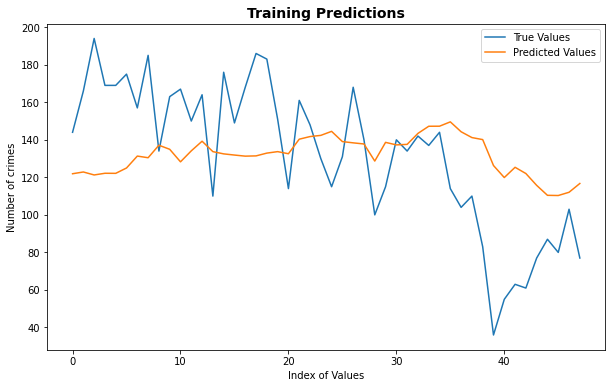

In [197]:
# plot the true and predicted values
plt.figure(figsize=(10,6))
plt.title('Training Predictions',weight='bold',size=14)
plt.xlabel('Index of Values')
plt.ylabel('Number of crimes')
plt.plot(y_train,label='True Values')
plt.plot(model.predict(X_train),label='Predicted Values')
plt.legend(loc='best')
plt.gcf().set_facecolor('white');

In [198]:
def plot_predictions(model, label=str):
    
    y_true = y_test
    y_hat = model.predict(X_test)

    # plot the true and predicted values
    plt.figure(figsize=(10,6))
    plt.title('{} Model Predictions'.format(label),weight='bold',size=14)
    plt.xlabel('Index of Values')
    plt.ylabel('Number of crimes')
    plt.plot(y_true,label='True Values')
    plt.plot(y_hat,label='Predicted Values')
    plt.legend(loc='best')
    plt.gcf().set_facecolor('white');

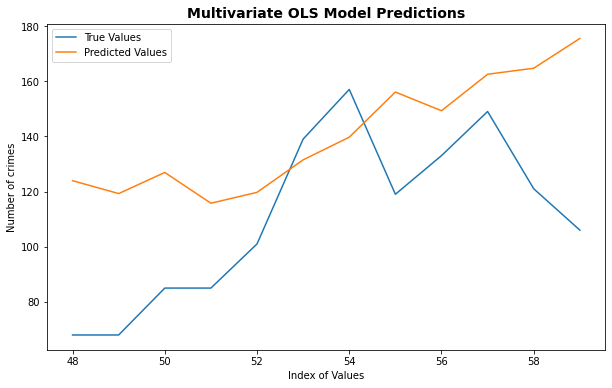

In [199]:
plot_predictions(model,'Multivariate OLS')

## Univariate Time Series Analysis
`Features`: Total_Crimes \
`Target`: Total_Crimes \
\
`X_train`: First 3 consecutive values of crimes \
`Target\ y_train`: Fourth crime value

In [200]:
train_data = df[df.Month.dt.year <= 2020]['Total_Crimes']
test_data =  df[df.Month.dt.year==2021]['Total_Crimes']

In [201]:
def sampling(sequence, n_steps):

    X, Y = list(), list()

    for i in range(len(sequence)):

        sam = i + n_steps
        if sam > len(sequence)-1:
            break

        x, y = sequence[i:sam], sequence[sam]

        X.append(x)

        Y.append(y)

    return np.array(X), np.array(Y)

In [202]:
n_steps = 3


X_train, y_train = sampling(train_data.tolist(), n_steps)
X_test, y_test = sampling(test_data.tolist(), n_steps)

In [203]:
model_uni = sm.OLS(y_train, X_train).fit()
model_uni.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              464.6
Date:                Wed, 30 Mar 2022   Prob (F-statistic):                    3.20e-32
Time:                        11:59:19   Log-Likelihood:                         -205.13
No. Observations:                  45   AIC:                                      416.3
Df Residuals:                      42   BIC:                                      421.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2256      0.145      1.559      0.127      -0.067       0.518
x2             0.2217      0.166      1.333      0.190      -0.114       0.558
x3             0.5191      0.146      3.556      0.001       0.224       0.814
==============================================================================
Omnibus:                        1.901   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.472
Skew:                          -0.443   Prob(JB):                        0.479
Kurtosis:                       2.966   Cond. No.                         13.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

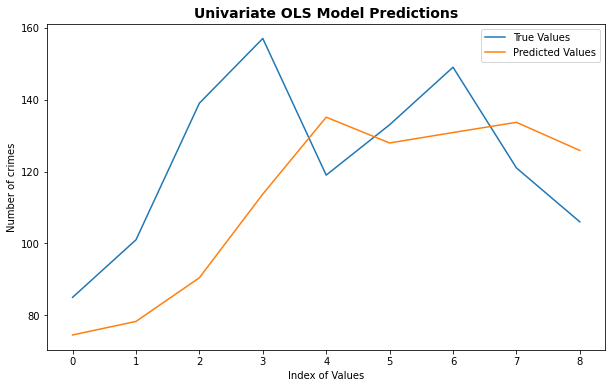

In [204]:
plot_predictions(model_uni, 'Univariate OLS')